In [1]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# distribution
from scipy.stats import norm, bernoulli

## Read

In [2]:
mndata = MNIST('./mnist data/')
mndata.gz = True
# 6000 images with 28*28 size
images, labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

## Stretch and Bound

In [3]:
def stretch_bound(image, stretch=True):
    
    # list to array shape 28 x 28
    pixels = np.array(image, dtype='uint8')
    pixels[pixels<127]=0
    pixels = pixels.reshape((28,28))
    
    # nonzero returns row and column nonzero index
    x = np.nonzero(pixels)[0]
    y = np.nonzero(pixels)[1]
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    
    x_center = np.mean([x_min, x_max])
    y_center = np.mean([y_min, y_max])
    
    if(stretch):
        # bound box
        box = pixels[x_min:x_max, y_min:y_max]

        # resize box
        box = cv2.resize(box, (20,20))
    else:
        # bound box
        box = pixels[x_center-10:x_center+10, y_center-10:y_center+10]
        
    
    return box

In [4]:
stretch_images = [stretch_bound(image) for image in images]
test_stretch_images = [stretch_bound(image) for image in test_images]
stretch_images[0].shape

(20, 20)

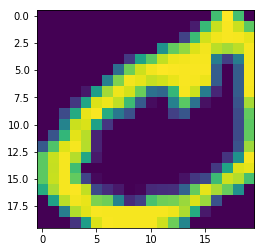

In [5]:
plt.imshow(stretch_images[21])
plt.show()

In [6]:
# put images and labels in one dataframe
images_reshape = pd.DataFrame([image.reshape(-1) for image in stretch_images])
stretched_train = pd.concat([images_reshape, pd.Series(labels, name='labels')], axis=1)

# untouched images
images_reshape = pd.DataFrame([np.array(image) for image in images])
images_reshape[images_reshape<127]=0
untouched_train = pd.concat([images_reshape, pd.Series(labels, name='labels')], axis=1)

# stretched test set
images_reshape = pd.DataFrame([image.reshape(-1) for image in test_stretch_images])
stretched_test = pd.concat([images_reshape, pd.Series(test_labels, name='labels')], axis=1)

# untouched test images
images_reshape = pd.DataFrame([np.array(image) for image in test_images])
images_reshape[images_reshape<127]=0
untouched_test = pd.concat([images_reshape, pd.Series(test_labels, name='labels')], axis=1)


## Mean Image

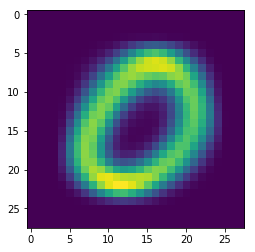

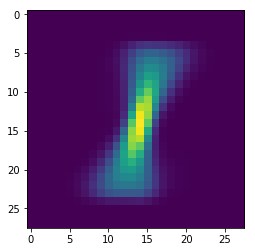

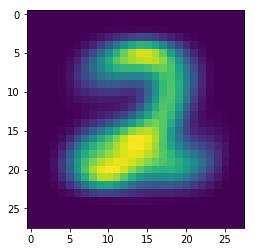

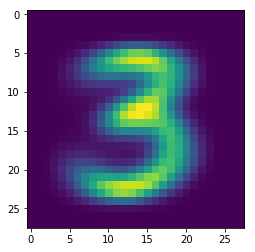

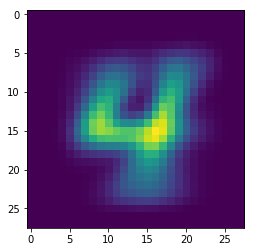

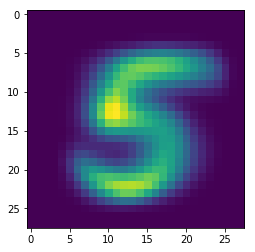

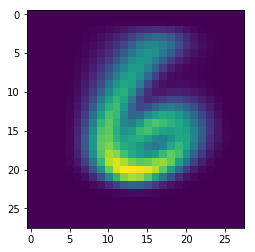

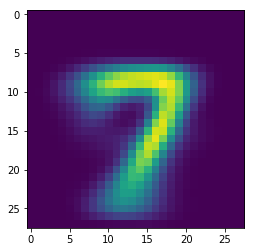

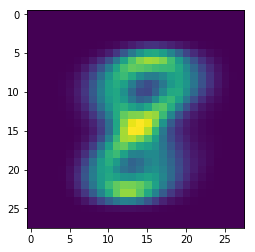

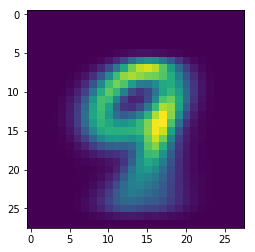

In [7]:
mean_images = np.array(untouched_train.groupby('labels').mean())
mean_images = mean_images.reshape(-1, 28,28)
for i in np.arange(mean_images.shape[0]):
    plt.imshow(mean_images[i,:])
    plt.show()

## Normal Model

In [19]:
def normal_nb(trainData, testData, target, print_train=False):
    
    # count each labels
    count = trainData.groupby(target).count()[0]
    n = trainData.shape[0]
    
    # create empty dataframe for results
    results = pd.DataFrame(None)
    
    # caclucate mean and var
    mu = trainData.groupby(target).mean()
    var = trainData.groupby(target).var()
    
    # threshold variance
    var[var==0] = 1e-06

    # train accuracy
    if(print_train):
        train = trainData.drop(target, axis=1)
        actual = trainData[target]
        for index in mu.index:
            prob = -(train-mu.loc[index,:])**2 / (2*var.loc[index,:]) +np.log(1/(np.sqrt(2*np.pi*var.loc[index,:])))
            result = np.sum(prob, axis=1) + np.log(count[index]/n)
            results = pd.concat([results, pd.Series(result, name=index)], axis=1)
    # test accuracy
    else:
        test = testData.drop(target, axis=1)
        actual = testData[target]
        # loop and calculate probabilities
        for index in mu.index:
            prob = -(test-mu.loc[index,:])**2 /  (2*var.loc[index,:]) +np.log(1/(np.sqrt(2*np.pi*var.loc[index,:])))
            result = np.sum(prob, axis=1) + np.log(count[index]/n)
            results = pd.concat([results, pd.Series(result, name=index)], axis=1)
        
    pred = np.argmax(results.values, axis=1)
    accuracy = np.sum(pred==actual)/len(pred)
    return accuracy

In [20]:
untouchTrainAcc= normal_nb(untouched_train, untouched_test, 'labels', True)
print(untouchTrainAcc)
untouchTestAcc= normal_nb(untouched_train, untouched_test, 'labels', False)
print(untouchTestAcc)
stretchTrainAcc = normal_nb(stretched_train, stretched_test, 'labels', True)
print(stretchTrainAcc)
stretchTestAcc = normal_nb(stretched_train, stretched_test, 'labels', False)
print(stretchTestAcc)

0.54035
0.535
0.8185833333333333
0.8268


### Norm comparison

In [10]:
from sklearn.naive_bayes import GaussianNB


nb = GaussianNB()
nb.fit(untouched_train.drop('labels', axis=1), labels)
pred = nb.predict(untouched_train.drop('labels', axis=1))
# untouched train acc
print(np.sum(pred==labels)/len(pred))
pred = nb.predict(untouched_test.drop('labels', axis=1))
# untouched test acc
print(np.sum(pred==test_labels)/len(pred))

nb = GaussianNB()
nb.fit(stretched_train.drop('labels', axis=1), labels)
pred = nb.predict(stretched_train.drop('labels', axis=1))
# stretched train acc
print(np.sum(pred==labels)/len(pred))
pred = nb.predict(stretched_test.drop('labels', axis=1))
# stretched test acc
print(np.sum(pred==test_labels)/len(pred))

0.5543166666666667
0.5497
0.8186166666666667
0.8268


## Bernoli Model

In [14]:
def bernoulli_nb(trainData, testData, target, print_train=False):
    # count each labels
    count = trainData.groupby(target).count()[0]
    n = trainData.shape[0]
    
    # calculate py: # of class j / # of total examples
    py = count/n
    
    # change data to binary
    train = trainData.copy()
    train[train.drop(target, axis=1)>0]=1
    
    # prob for each variable hatp: # of class j with xi= 1 / # of class j
    hatp = np.divide(train.groupby(target).sum()+1, np.array(count).reshape(-1,1)+2)
    
    # train accuracy
    if(print_train):
        # actual
        actual = trainData[target]
        test = train.copy()
        
    # test accuracy
    else:
        # actual
        actual = testData[target]
        
        # change data to binary
        test = testData.copy()
        test[test.drop(target, axis=1)>0]=1
        
    # log conditional prob
    test = test.drop(target, axis=1)
    # positive part
    pos = np.dot(test, np.log(hatp).T) # n, 10
    # negative part
    neg = np.dot(1-test, np.log(1-hatp).T)
    # sum up two pos and neg with log prior
    prob = np.add(pos,neg)+np.array(py).reshape(-1)
    pred = np.argmax(prob, axis=1)
    accuracy = np.sum(pred==actual)/test.shape[0]
        
    
    return accuracy

In [15]:
untouchTrainAcc= bernoulli_nb(untouched_train, untouched_test, 'labels', True)
print(untouchTrainAcc)
untouchTestAcc= bernoulli_nb(untouched_train, untouched_test, 'labels', False)
print(untouchTestAcc)
stretchTrainAcc = bernoulli_nb(stretched_train, stretched_test, 'labels', True)
print(stretchTrainAcc)
stretchTestAcc = bernoulli_nb(stretched_train, stretched_test, 'labels', False)
print(stretchTestAcc)

0.8358
0.843
0.8090666666666667
0.8247


### Bern Comparison

In [16]:
from sklearn.naive_bayes import BernoulliNB


nb = BernoulliNB()
nb.fit(untouched_train.drop('labels', axis=1), labels)
pred = nb.predict(untouched_train.drop('labels', axis=1))
# untouched train acc
print(np.sum(pred==labels)/len(pred))
pred = nb.predict(untouched_test.drop('labels', axis=1))
# untouched test acc
print(np.sum(pred==test_labels)/len(pred))

nb = BernoulliNB()
nb.fit(stretched_train.drop('labels', axis=1), labels)
pred = nb.predict(stretched_train.drop('labels', axis=1))
# stretched train acc
print(np.sum(pred==labels)/len(pred))
pred = nb.predict(stretched_test.drop('labels', axis=1))
# stretched test acc
print(np.sum(pred==test_labels)/len(pred))

0.8358166666666667
0.8427
0.8089
0.8247


## Decision Tree

In [ ]:
for test in data:
    test[0].drop(target, axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators (10, 30) max_depth (4, 10)
data = [[untouched_train, untouched_test], [stretched_train, stretched_test]]
estimators = [10, 30]
max_depths = [4, 16]
for n_estimators in estimators:
    for max_depth in max_depths:
        for data_set in data:
            # train
            print(data_set[0].shape[1])
            unforest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            unforest.fit(data_set[0].drop(target, axis= 1), data_set[0][target])
            pred = unforest.predict(data_set[0].drop(target, axis= 1))
            accuracy = np.sum(pred==data_set[0][target])/data_set[0].shape[0]
            print("train - # of tree: "+str(n_estimators)+", max_depth: "+str(max_depth)+", accuracy: " +str(accuracy))
            pred = unforest.predict(data_set[1].drop(target, axis= 1))
            accuracy = np.sum(pred==data_set[1][target])/data_set[1].shape[0]
            print("test - # of tree: "+str(n_estimators)+", max_depth: "+str(max_depth)+", accuracy: " +str(accuracy))
        

In [ ]:
np.where((data_set[0].shape[1] ==785), print('untouched') , print('stretched') )